In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 31.5 MB/s eta 0:00:0000:0100:01


Importing Necessary Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
main_folder_path = "/kaggle/input/cropped-faces/cropped_faces"

Reading Image Paths Into A List

In [4]:
image_paths = []
label = []
for folder in os.listdir(main_folder_path):
    category_path = os.path.join(main_folder_path, folder)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        label.append(folder)

Facial Landmark Detection & Face Warping

In [11]:
import cv2
import mediapipe as mp

def face_alignment(image_path):
    mp_face_mesh=mp.solutions.face_mesh
    mp_drawing=mp.solutions.drawing_utils
    mp_drawing_styles =mp.solutions.drawing_styles

    imgg = cv2.imread(image_path)
    if imgg is not None:
        # applying face mesh model using MediaPipe
        img=cv2.cvtColor(imgg,cv2.COLOR_BGR2RGB)
        results=mp_face_mesh.FaceMesh(max_num_faces=2,refine_landmarks=True,min_detection_confidence=0.7,min_tracking_confidence=0.6).process(img)


        # draw annotations on the image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:

                mp_drawing.draw_landmarks(
                image=img,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
                    )

                mp_drawing.draw_landmarks(
                image=img,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
                    )

                mp_drawing.draw_landmarks(
                image=img,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_IRISES,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style()
                    )
            # Extract landmarks for left eye, right eye, and nose tip
                left_eye_center = (face_landmarks.landmark[33].x * img.shape[1], face_landmarks.landmark[33].y * img.shape[0])
                right_eye_center = (face_landmarks.landmark[263].x * img.shape[1], face_landmarks.landmark[263].y * img.shape[0])
                #nose_tip = (face_landmarks.landmark[168].x * img.shape[1], face_landmarks.landmark[168].y * img.shape[0])
                mouth_center = (face_landmarks.landmark[62].x * img.shape[1], face_landmarks.landmark[62].y * img.shape[0])

            # Define reference points for left eye, right eye, and nose tip on the cropped face image
                reference_points = [
                (75, 100),  # Example reference point for left eye
                (125, 100),  # Example reference point for right eye
                (90,150),  # Example reference point for mouth center
                ]

                # Convert landmarks and reference points to numpy arrays
                landmarks = np.float32([left_eye_center, right_eye_center, mouth_center])
                reference_points = np.float32(reference_points)

                # Calculate the transformation matrix using getAffineTransform
                M = cv2.getAffineTransform(landmarks, reference_points)
          
                # Warp the cropped face image using the transformation matrix
                warped_face = cv2.warpAffine(imgg, M, (img.shape[1], img.shape[0]))
                # Find the non-zero pixels in the warped_face image
                # Convert warped_face to grayscale
                warped_face_gray = cv2.cvtColor(warped_face, cv2.COLOR_BGR2GRAY)

                # Find the non-zero pixels in the warped_face_gray image
                non_zero_pixels = cv2.findNonZero(warped_face_gray)

                # Get the bounding box that contains all the non-zero pixels
                x, y, w, h = cv2.boundingRect(non_zero_pixels)

                # Crop the warped_face image to the bounding box
                cropped_warped_face = warped_face[y:y+h, x:x+w]
                cropped_warped_face = cv2.resize(cropped_warped_face,(256,256))
                return cropped_warped_face,img



# plt.imshow(img)
# plt.show()
# plt.imshow(cropped_warped_face)
# plt.show()
            

Saving The Warped Images

In [ ]:
# Create a folder to save the cropped images
output_folder = "/kaggle/working/aligned_faces"
os.makedirs(output_folder, exist_ok=True)

for i in tqdm(range(490,734),desc = "loading"):
    face_image = face_alignment(image_paths[i])
    if face_image is not None:
        new_folder = os.path.join(output_folder, str(label[i]))
        os.makedirs(new_folder, exist_ok=True)  
        output_path = os.path.join(new_folder, f"face_{i+1}.jpg")
        cv2.imwrite(output_path, face_image)

In [ ]:
!zip -r file.zip /kaggle/working/aligned_faces

Visualizing Facial Landmark & Mesh

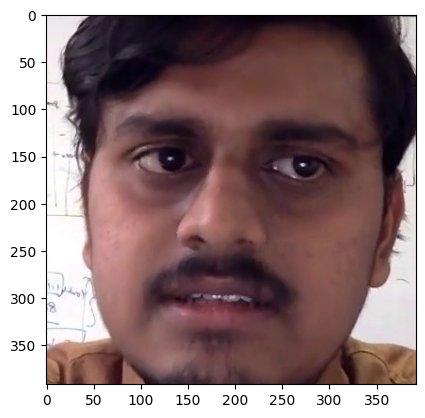

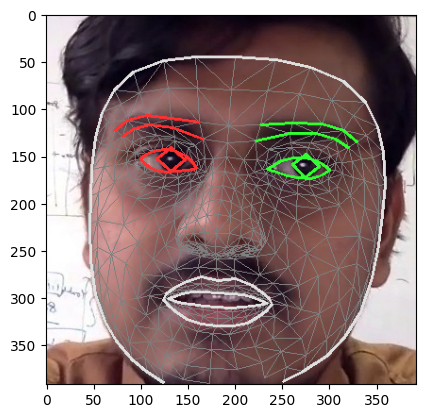

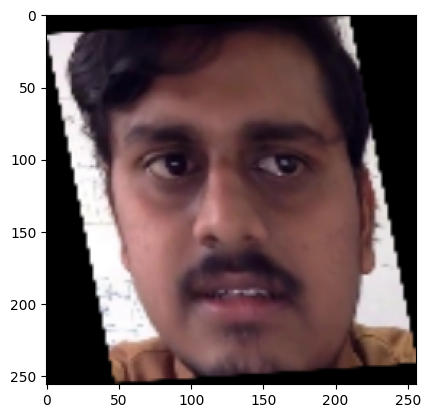

In [13]:
import matplotlib.pyplot as plt

# Load an image using OpenCV
image = cv2.imread("/kaggle/input/cropped-faces/cropped_faces/IMT2012017/face_13.jpg")
warped_face,img = face_alignment("/kaggle/input/cropped-faces/cropped_faces/IMT2012017/face_13.jpg")

# Convert BGR image to RGB format (Matplotlib expects RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
warped_face = cv2.cvtColor(warped_face, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.show()
plt.imshow(img)
plt.show()
plt.imshow(warped_face)
plt.show()